C:\Users\mmm\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


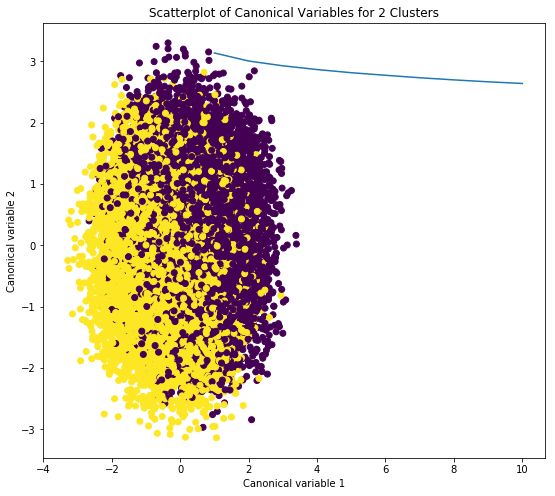

Clustering variable means by cluster
                index        S1        C1        S2        C2        S3  \
cluster                                                                   
0        12481.226780 -0.019240  0.001804  0.898617 -0.002745 -0.030163   
1        12527.595236  0.019092 -0.001790 -0.891745  0.002724  0.029933   

               C3        S4        C4        S5        C5  
cluster                                                    
0       -0.004830 -0.018393  0.011585 -0.009840  0.006978  
1        0.004793  0.018252 -0.011496  0.009765 -0.006924  
                            OLS Regression Results                            
Dep. Variable:                  CLASS   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.214
Date:                Sun, 15 Oct 2017   Prob (F-statistic):              0.271
Time:                      

In [1]:
# load libraries
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
import urllib.request
from pylab import rcParams
rcParams['figure.figsize'] = 9, 8

'''
GET DATA
'''

# read training and test data from the url link and save the file to your working directory
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data"

urllib.request.urlretrieve(url, "poker_train.csv")

url2 = "http://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-testing.data"

urllib.request.urlretrieve(url2, "poker_test.csv")

# read the data in and add column names
data_train = pd.read_csv("poker_train.csv", header=None,
                        names=['S1', 'C1', 'S2', 'C2', 'S3', 'C3','S4', 'C4', 'S5', 'C5', 'CLASS'])

data_test = pd.read_csv("poker_test.csv", header=None,
                        names=['S1', 'C1', 'S2', 'C2', 'S3', 'C3','S4', 'C4', 'S5', 'C5', 'CLASS'])

'''
EXPLORE THE DATA
'''
# summary statistics including counts, mean, stdev, quartiles for the training dataset
data_train.head(n=5)
data_train.dtypes # data types of each variable
data_train.describe()

'''
SUBSET THE DATA
'''
# subset clustering variables
cluster=data_train[['S1', 'C1', 'S2', 'C2', 'S3', 'C3','S4', 'C4', 'S5', 'C5']]

'''
STANDARDIZE THE DATA
'''
# standardize clustering variables to have mean=0 and sd=1 so that card suit and
# rank are on the same scale as to have the variables equally contribute to the analysis
clustervar=cluster.copy() # create a copy
clustervar['S1']=preprocessing.scale(clustervar['S1'].astype('float64'))
clustervar['C1']=preprocessing.scale(clustervar['C1'].astype('float64'))
clustervar['S2']=preprocessing.scale(clustervar['S2'].astype('float64'))
clustervar['C2']=preprocessing.scale(clustervar['C2'].astype('float64'))
clustervar['S3']=preprocessing.scale(clustervar['S3'].astype('float64'))
clustervar['C3']=preprocessing.scale(clustervar['C3'].astype('float64'))
clustervar['S4']=preprocessing.scale(clustervar['S4'].astype('float64'))
clustervar['C4']=preprocessing.scale(clustervar['C4'].astype('float64'))
clustervar['S5']=preprocessing.scale(clustervar['S5'].astype('float64'))
clustervar['C5']=preprocessing.scale(clustervar['C5'].astype('float64'))

# The data has been already split data into train and test sets
clus_train = clustervar
'''
K-MEANS ANALYSIS - INITIAL CLUSTER SET
'''
# k-means cluster analysis for 1-10 clusters due to the 10 possible class outcomes for poker hands                                                       
from scipy.spatial.distance import cdist
clusters=range(1,11)
meandist=[]

# loop through each cluster and fit the model to the train set
# generate the predicted cluster assingment and append the mean distance my taking the sum divided by the shape
for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1))
    / clus_train.shape[0])

"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method') # pick the fewest number of clusters that reduces the average distance

# Interpret 2 cluster solution
model3=KMeans(n_clusters=2)
model3.fit(clus_train) # has cluster assingments based on using 3 clusters
clusassign=model3.predict(clus_train)

# plot clusters
''' Canonical Discriminant Analysis for variable reduction:
1. creates a smaller number of variables
2. linear combination of clustering variables
3. Canonical variables are ordered by proportion of variance accounted for
4. most of the variance will be accounted for in the first few canonical variables
'''
from sklearn.decomposition import PCA # CA from PCA function
pca_2 = PCA(2) # return 2 first canonical variables
plot_columns = pca_2.fit_transform(clus_train) # fit CA to the train dataset
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,) # plot 1st canonical variable on x axis, 2nd on y-axis
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 2 Clusters')
plt.show() # close or overlapping clusters idicate correlated variables with low in-class variance but not good separation. 2 cluster might be better.

"""
BEGIN multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
"""
# create a unique identifier variable from the index for the
# cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)
# create a list that has the new index variable
cluslist=list(clus_train['index'])
# create a list of cluster assignments
labels=list(model3.labels_)
# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))
newlist
# convert newlist dictionary to a dataframe
newclus=DataFrame.from_dict(newlist, orient='index')
newclus
# rename the cluster assignment column
newclus.columns = ['cluster']

# now do the same for the cluster assignment variable create a unique identifier variable from the index for the
# cluster assignment dataframe to merge with cluster training data
newclus.reset_index(level=0, inplace=True)
# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=100)
# cluster frequencies
merged_train.cluster.value_counts()

"""
END multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
"""

# FINALLY calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

'''
validate clusters in training data by examining cluster differences in CLASS using ANOVA
first have to merge CLASS of poker hand with clustering variables and cluster assignment data
'''
# split into test / train for class
pokerhand_train=data_train['CLASS']
pokerhand_test=data_test['CLASS']
# put into a pandas dataFrame
pokerhand_train=pd.DataFrame(pokerhand_train)
pokerhand_test=pd.DataFrame(pokerhand_test)
pokerhand_train.reset_index(level=0, inplace=True) # reset index
merged_train_all=pd.merge(pokerhand_train, merged_train, on='index') # merge the pokerhand train with merged clusters
sub1 = merged_train_all[['CLASS', 'cluster']].dropna()

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

# respone formula
pokermod = smf.ols(formula='CLASS ~ C(cluster)', data=sub1).fit()
print (pokermod.summary())

print ('means for Poker hands by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)

print ('standard deviations for Poker hands by cluster')
m2= sub1.groupby('cluster').std()
print (m2)

mc1 = multi.MultiComparison(sub1['CLASS'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

